Load files, libraries

In [157]:
%matplotlib inline
from msmbuilder.io import gather_metadata, save_meta, NumberedRunsParser

## Construct and save the dataframe
parser = NumberedRunsParser(
    traj_fmt="md.loop_SC_{run}.xtc",
    top_fn="md.loop_SC_start.gro",
    step_ps=100,
)
meta = gather_metadata("*SC*.xtc", parser)
save_meta(meta)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: meta.pandas.pickl exists. Moving it to meta.pandas.pickl.bak.3
  BackupWarning)


In [158]:
import matplotlib
matplotlib.use('Agg')
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from msmbuilder.io import load_meta, render_meta

sns.set_style('ticks')
colors = sns.color_palette()


/Users/sbamos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sbamos/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sbamos/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sbamos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sbamos/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sbamos/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in s

Get some info about the trajectories

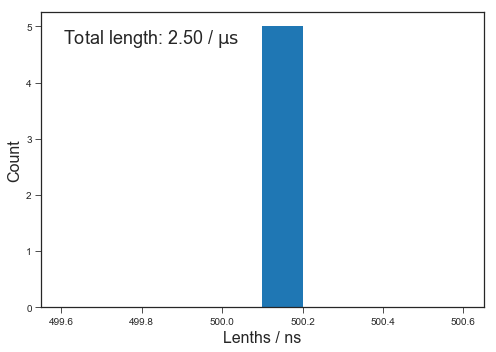

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: meta.pandas.html exists. Moving it to meta.pandas.html.bak.4
  BackupWarning)


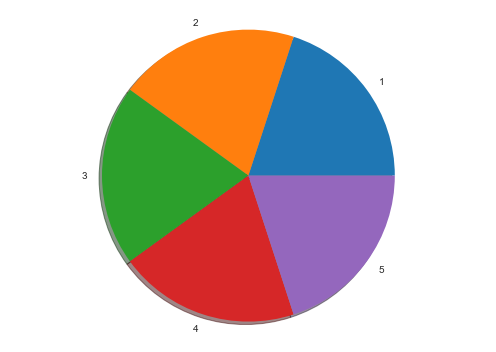

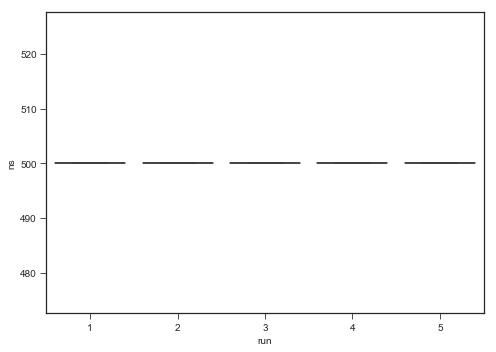

In [164]:
## Load
meta = load_meta()


## Histogram of trajectory lengths
def plot_lengths(ax):
    lengths_ns = meta['nframes'] * (meta['step_ps'] / 1000)
    ax.hist(lengths_ns)
    ax.set_xlabel("Lenths / ns", fontsize=16)
    ax.set_ylabel("Count", fontsize=16)

    total_label = ("Total length: {us:.2f}"
                   .format(us=np.sum(lengths_ns) / 1000))
    total_label += r" / $\mathrm{\mu s}$"
    ax.annotate(total_label,
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                fontsize=18,
                va='top',
                )
    
## Pie graph
def plot_pie(ax):
    lengths_ns = meta['nframes'] * (meta['step_ps'] / 1000)
    sampling = lengths_ns.groupby(level=0).sum()

    ax.pie(sampling,
           shadow=True,
           labels=sampling.index,
           colors=sns.color_palette(),
           )
    ax.axis('equal')

## Box plot
def plot_boxplot(ax):
    meta2 = meta.copy()
    meta2['ns'] = meta['nframes'] * (meta['step_ps'] / 1000)
    sns.boxplot(
        x=meta2.index.names[0],
        y='ns',
        data=meta2.reset_index(),
        ax=ax,
    )


## Plot hist
fig, ax = plt.subplots(figsize=(7, 5))
plot_lengths(ax)
fig.tight_layout()
fig.savefig("lengths-hist.pdf")
plt.show()
#

## Plot pie
fig, ax = plt.subplots(figsize=(7, 5))
plot_pie(ax)
fig.tight_layout()
fig.savefig("lengths-pie.pdf")
#

## Plot box
fig, ax = plt.subplots(figsize=(7, 5))
plot_boxplot(ax)
fig.tight_layout()
fig.savefig("lengths-boxplot.pdf")
#

## Save metadata as html table
render_meta(meta, 'meta.pandas.html')

Featurize

In [267]:
# Turn trajectories into dihedral features

import mdtraj as md

from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.io import load_meta, preload_tops, save_trajs, save_generic
from multiprocessing import Pool

## Load
meta = load_meta()
tops = preload_tops(meta)
dihed_feat = DihedralFeaturizer(types=['phi', 'psi', 'chi1'])


## Featurize logic
def feat(irow):
    i, row = irow
    traj = md.load(row['traj_fn'], top=tops[row['top_fn']])
    feat_traj = dihed_feat.partial_transform(traj)
    return i, feat_traj


## Do it in parallel
with Pool() as pool:
    dihed_trajs = dict(pool.imap_unordered(feat, meta.iterrows()))



## Save
save_trajs(dihed_trajs, 'ftrajs', meta)
save_generic(dihed_feat, 'featurizer.pickl')

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: ftrajs exists. Moving it to ftrajs.bak.7
  BackupWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: featurizer.pickl exists. Moving it to featurizer.pickl.bak.7
  BackupWarning)


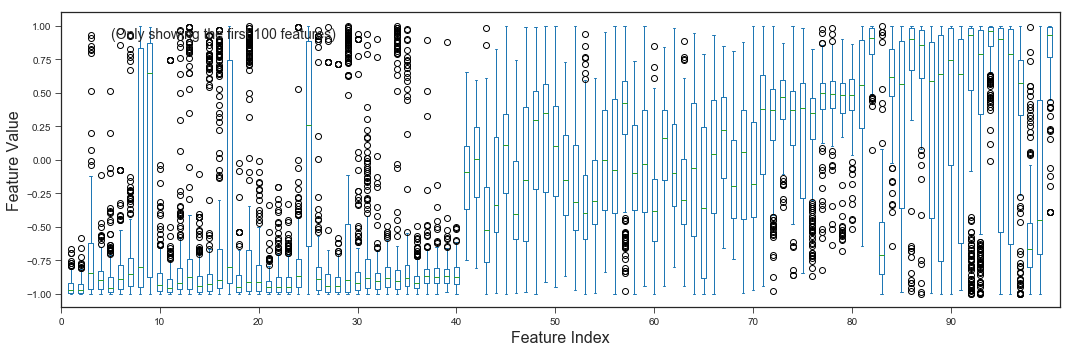

In [268]:
# Plot diagnostic feature info

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from msmbuilder.io import load_trajs

sns.set_style('ticks')
colors = sns.color_palette()

## Load
meta, ftrajs = load_trajs('ftrajs')


# (stride by 100 for memory concerns)
fxx = np.concatenate([fx[::100] for fx in ftrajs.values()])


## Box and whisker plot
def plot_box(ax):
    n_feats_plot = min(fxx.shape[1], 100)
    ax.boxplot(fxx[:, :100],
               boxprops={'color': colors[0]},
               whiskerprops={'color': colors[0]},
               capprops={'color': colors[0]},
               medianprops={'color': colors[2]},
               )

    if fxx.shape[1] > 100:
        ax.annotate("(Only showing the first 100 features)",
                    xy=(0.05, 0.95),
                    xycoords='axes fraction',
                    fontsize=14,
                    va='top',
                    )

    ax.set_xlabel("Feature Index", fontsize=16)
    xx = np.arange(0, n_feats_plot, 10)
    ax.set_xticks(xx)
    ax.set_xticklabels([str(x) for x in xx])
    ax.set_xlim((0, n_feats_plot + 1))
    ax.set_ylabel("Feature Value", fontsize=16)


## Plot
fig, ax = plt.subplots(figsize=(15, 5))
plot_box(ax)
fig.tight_layout()
plt.show()
#fig.savefig("ftrajs-box.pdf")
#

Dimensionality reduction - tICA

In [269]:
#Reduce dimensionality with tICA

from msmbuilder.io import load_trajs, save_trajs, save_generic
from msmbuilder.decomposition import tICA

## Load
tica = tICA(n_components=5, lag_time=100, kinetic_mapping=True)
meta, ftrajs = load_trajs("ftrajs")

## Fit
t = tica.fit(ftrajs.values())
tica.fit(ftrajs.values())

## Transform
ttrajs = {}
for k, v in ftrajs.items():
    ttrajs[k] = tica.partial_transform(v)
    
##### IF SCALING



## Save
save_trajs(ttrajs, 'ttrajs', meta)
save_generic(tica, 'tica.pickl')

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: ttrajs exists. Moving it to ttrajs.bak.6
  BackupWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: tica.pickl exists. Moving it to tica.pickl.bak.6
  BackupWarning)


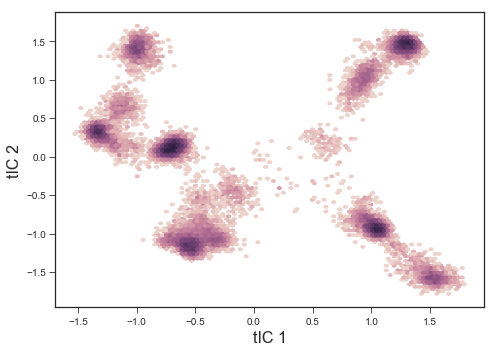

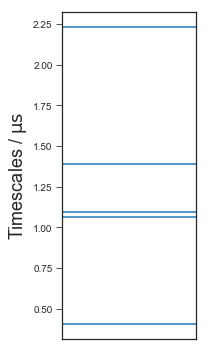

In [270]:
#"""Plot tICA-transformed coordinates

from msmbuilder.io import load_trajs, load_generic

sns.set_style('ticks')
colors = sns.color_palette()

## Load
tica = load_generic('tica.pickl')
meta, ttrajs = load_trajs('ttrajs')
txx = np.concatenate(list(ttrajs.values()))


## Heatmap
def plot_heatmap(ax):
    ax.hexbin(txx[:, 0], txx[:, 1],
              cmap=sns.cubehelix_palette(as_cmap=True),
              mincnt=1,
              bins='log'
              )
    ax.set_xlabel("tIC 1", fontsize=16)
    ax.set_ylabel("tIC 2", fontsize=16)

## Timescales
def plot_timescales(ax):
    timestep = meta['step_ps'].unique()
    assert len(timestep) == 1, timestep
    timestep = float(timestep[0])  # ps
    to_us = (
        (1.0 / 1000)  # ps -> ns
        * (1.0 / 1000)  # ns -> us
        * (timestep / 1)  # steps -> ps
    )
    ax.hlines(tica.timescales_ * to_us,
              0, 1,
              color=colors[0])
    ax.set_ylabel(r'Timescales / $\mathrm{\mu s}$', fontsize=18)
    ax.set_xticks([])
    ax.set_xlim((0, 1))


## Plot 1
fig, ax = plt.subplots(figsize=(7, 5))
plot_heatmap(ax)
fig.tight_layout()
plt.show()
#fig.savefig('tica-heatmap.pdf')
#

## Plot 2
fig, ax = plt.subplots(figsize=(3, 5))
plot_timescales(ax)
fig.tight_layout()
plt.show()
#fig.savefig('tica-timescales.pdf')

(25005, 5)
()


/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


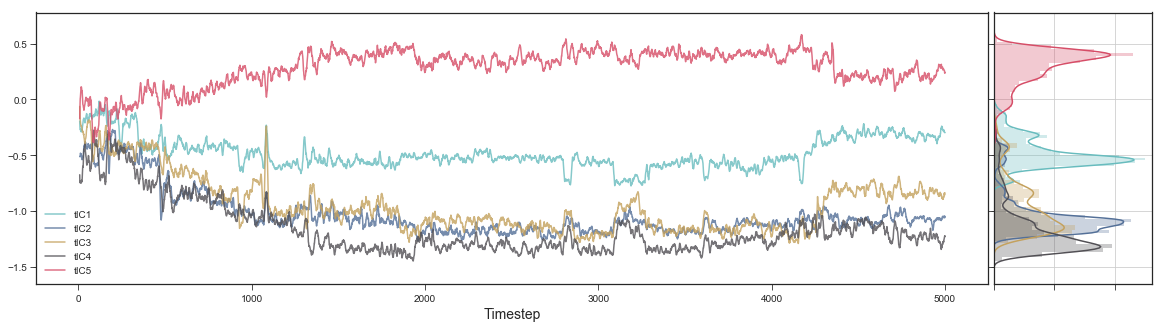

In [271]:
# MSME plotting

import msmexplorer as msme
print(np.shape(txx))
print(np.shape(ttrajs))

tica_model = tICA(lag_time=100, n_components=5, kinetic_mapping=True)
tica_trajs = tica_model.fit_transform(ftrajs.values())

ax, side_ax = msme.plot_trace(tica_trajs[0][:, 0], window=10,
                              label='tIC1', xlabel='Timestep')
_ = msme.plot_trace(tica_trajs[0][:, 1], window=10, label='tIC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
__ = msme.plot_trace(tica_trajs[0][:, 2], window=10, label='tIC3',
                    xlabel='Timestep', color='dijon', ax=ax,
                    side_ax=side_ax)
___ = msme.plot_trace(tica_trajs[0][:, 3], window=10, label='tIC4',
                    xlabel='Timestep', color='carbon', ax=ax,
                    side_ax=side_ax)
____ = msme.plot_trace(tica_trajs[0][:, 4], window=10, label='tIC5',
                    xlabel='Timestep', color='pomegranate', ax=ax,
                    side_ax=side_ax)

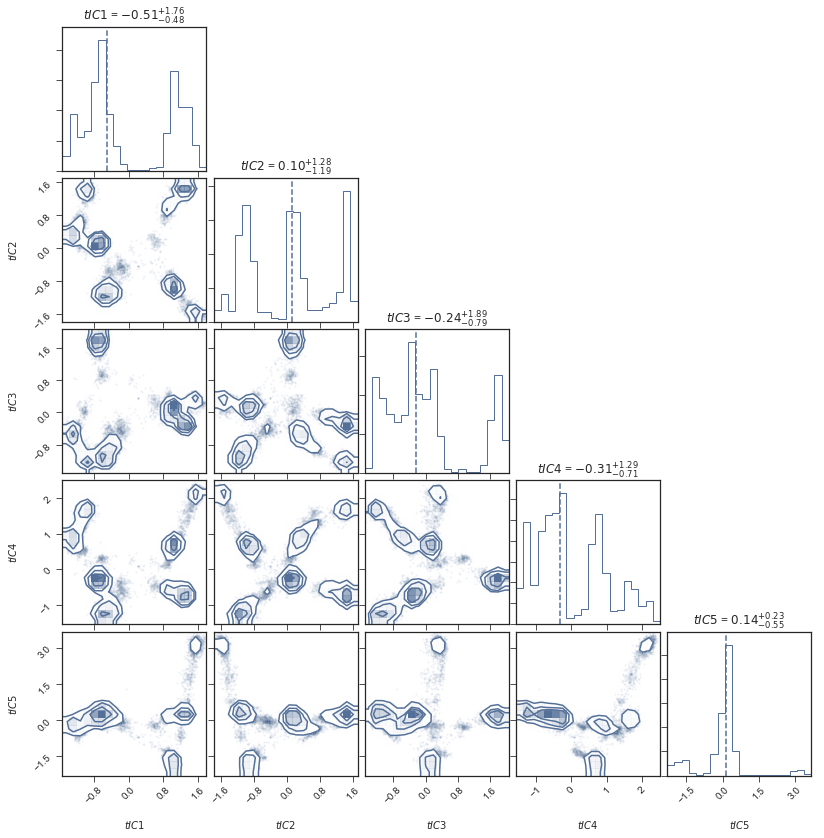

In [272]:
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx, labels=['$tIC1$', '$tIC2$', '$tIC3$', '$tIC4$', '$tIC5$'],
                    color='rawdenim', quantiles=(0.5,), smooth=0.5, show_titles=True)

Sample the tica dimension

In [273]:


from msmbuilder.io.sampling import sample_dimension
from msmbuilder.io import load_trajs, save_generic, preload_top, backup

## Load
meta, ttrajs = load_trajs('ttrajs')

## Sample
inds = sample_dimension(ttrajs,
                        dimension=0,
                        n_frames=200, scheme='random')

save_generic(inds, "tica-dimension-0-inds.pickl")

## Make trajectory
top = preload_top(meta)

# Use loc because sample_dimension is nice
traj = md.join(
    md.load_frame(meta.loc[traj_i]['traj_fn'], index=frame_i, top=top)
    for traj_i, frame_i in inds
)

## Save
traj_fn = "tica-dimension-0.xtc"
#backup(traj_fn)
traj.save(traj_fn)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: tica-dimension-0-inds.pickl exists. Moving it to tica-dimension-0-inds.pickl.bak.7
  BackupWarning)


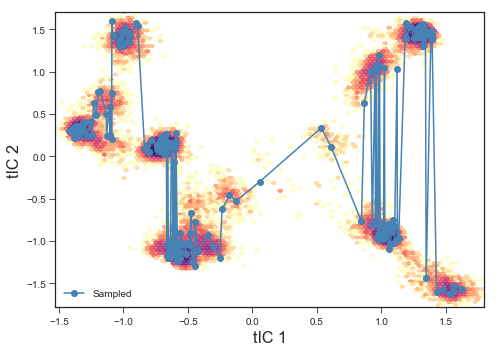

In [274]:
#plot result of sampling a tica coordinate

from msmbuilder.io import load_trajs, load_generic

sns.set_style('ticks')
colors = sns.color_palette()

## Load
meta, ttrajs = load_trajs('ttrajs')
txx = np.concatenate(list(ttrajs.values()))

inds = load_generic("tica-dimension-0-inds.pickl")
straj = []
for traj_i, frame_i in inds:
    straj += [ttrajs[traj_i][frame_i, :]]
straj = np.asarray(straj)


## Overlay sampled trajectory on histogram
def plot_sampled_traj(ax):
    ax.hexbin(txx[:, 0], txx[:, 1],
              cmap='magma_r',
              mincnt=1,
              bins='log',
              alpha=0.8,
              )

    ax.plot(straj[:, 0], straj[:, 1], 'o-', color='steelblue', label='Sampled')

    ax.set_xlabel("tIC 1", fontsize=16)
    ax.set_ylabel("tIC 2", fontsize=16)
    ax.legend(loc='best')


## Plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_sampled_traj(ax)
fig.tight_layout()
plt.show()
#fig.savefig('tica-dimension-0-heatmap.pdf')

Clustering

In [275]:
# cluster tica results

from msmbuilder.io import load_trajs, save_trajs, save_generic
#from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import KCenters
## Load
meta, ttrajs = load_trajs('ttrajs')

## Fit
dim = 5
kmeans = KCenters(n_clusters=10)

# we do this twice to be able to plot with msme and inbuilt
clusterer = kmeans.fit([traj[:, :dim] for traj in ttrajs.values()])
kmeans.fit([traj[:, :dim] for traj in ttrajs.values()])

## Transform
ktrajs = {}
for k, v in ttrajs.items():
    ktrajs[k] = kmeans.partial_transform(v[:, :dim])
    

## Save
print(kmeans.summarize())
save_trajs(ktrajs, 'ktrajs', meta)
save_generic(kmeans, 'kmeans.pickl')

KCenters clustering
--------------------
n_clusters : 10
metric     : euclidean

Inertia       : 12415.33642043233
Mean distance : 0.4965141539864959
Max  distance : 1.6180164865214022



/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: ktrajs exists. Moving it to ktrajs.bak.18
  BackupWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: kmeans.pickl exists. Moving it to kmeans.pickl.bak.18
  BackupWarning)


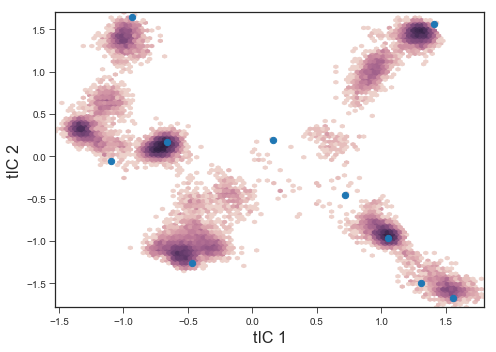

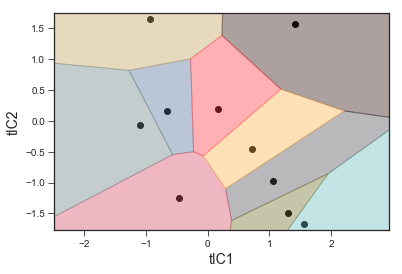

In [276]:
# plot clusters

from msmbuilder.io import load_trajs, load_generic

sns.set_style('ticks')
colors = sns.color_palette()

## Load
kmeans = load_generic('kmeans.pickl')
meta, ktrajs = load_trajs('ktrajs')
meta, ttrajs = load_trajs('ttrajs', meta)
txx = np.concatenate(list(ttrajs.values()))

assigns = np.asarray(ktrajs)

def plot_cluster_centers(ax):
    ax.hexbin(txx[:, 0], txx[:, 1],
              cmap=sns.cubehelix_palette(as_cmap=True),
              mincnt=1,
              bins='log',
              )
    ax.scatter(kmeans.cluster_centers_[:, 0],
               kmeans.cluster_centers_[:, 1],
               s=40, c=colors[0],
               )
    ax.set_xlabel("tIC 1", fontsize=16)
    ax.set_ylabel("tIC 2", fontsize=16)


## Plot 1
fig, ax = plt.subplots(figsize=(7, 5))
plot_cluster_centers(ax)
fig.tight_layout()
plt.show()
#fig.savefig('kmeans-centers.pdf')
#
_ = msme.plot_voronoi(clusterer, xlabel='tIC1', ylabel='tIC2')

Implied timescales

In [277]:
# Calculate implied timescales vs. lagtime
    
from multiprocessing import Pool

import pandas as pd

from msmbuilder.io import load_trajs
from msmbuilder.msm import MarkovStateModel

## Load
meta, ktrajs = load_trajs('ktrajs')

## Parameters
lagtimes = [2 ** i for i in range(8)]


## Define what to do for parallel execution
def at_lagtime(lt):
    msm = MarkovStateModel(lag_time=lt, n_timescales=5, verbose=False)
    msm.fit(list(ktrajs.values()))
    ret = {
        'lag_time': lt,
        'percent_retained': msm.percent_retained_,
    }
    for i in range(msm.n_timescales):
        ret['timescale_{}'.format(i)] = msm.timescales_[i]
    return ret


## Do the calculation
with Pool() as p:
    results = p.map(at_lagtime, lagtimes)

lt_df = pd.DataFrame(results)

## Save
print(lt_df.head())
lt_df.to_pickle('timescales.pandas.pickl')

   lag_time  percent_retained   timescale_0   timescale_1  timescale_2  \
0         1             100.0    728.732510    476.608551   385.820793   
1         2             100.0   1686.242444    953.267567   929.904627   
2         4             100.0   2857.549626   1911.622908  1521.225912   
3         8             100.0   6031.113994   4380.174619  3571.546228   
4        16             100.0  12501.490804  10181.993523  6662.562498   

   timescale_3  timescale_4  
0   199.390739    88.757706  
1   427.147279   180.485932  
2   793.745840   368.424343  
3  1473.491095   613.840261  
4  2811.643876  1111.074439  


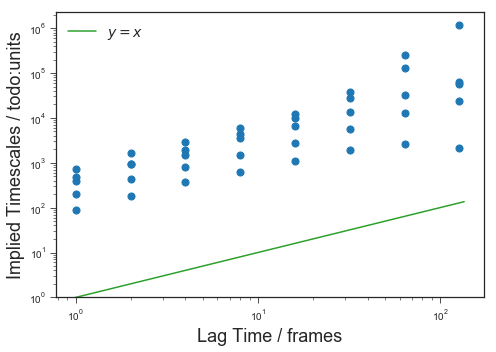

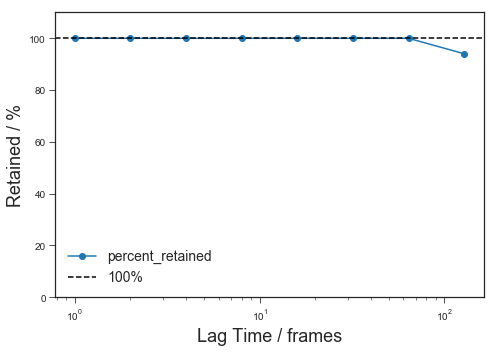

In [278]:
sns.set_style('ticks')
colors = sns.color_palette()

## Load
timescales = pd.read_pickle('timescales.pandas.pickl')
n_timescales = len([x for x in timescales.columns
                    if x.startswith('timescale_')])


## Implied timescales vs lagtime
def plot_timescales(ax):
    for i in range(n_timescales):
        ax.scatter(timescales['lag_time'],
                   timescales['timescale_{}'.format(i)],
                   s=50, c=colors[0],
                   label=None,  # pandas be interfering
                   )

    xmin, xmax = ax.get_xlim()
    xx = np.linspace(xmin, xmax)
    ax.plot(xx, xx, color=colors[2], label='$y=x$')
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel('Lag Time / frames', fontsize=18)
    ax.set_ylabel('Implied Timescales / todo:units', fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
## Percent trimmed vs lagtime
def plot_trimmed(ax):
    ax.plot(timescales['lag_time'],
            timescales['percent_retained'],
            'o-',
            label=None,  # pandas be interfering
            )
    ax.axhline(100, color='k', ls='--', label='100%')
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel('Lag Time / frames', fontsize=18)
    ax.set_ylabel('Retained / %', fontsize=18)
    ax.set_xscale('log')
    ax.set_ylim((0, 110))

## Plot timescales
fig, ax = plt.subplots(figsize=(7, 5))
plot_timescales(ax)
fig.tight_layout()
plt.show()
#fig.savefig('implied-timescales.pdf')
#

## Plot trimmed
fig, ax = plt.subplots(figsize=(7,5))
plot_trimmed(ax)
fig.tight_layout()
plt.show()
#fig.savefig('percent-trimmed.pdf')
#

Markov State Model

Markov state model
------------------
Lag time         : 50
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 10
Number of nonzero entries in counts matrix : 33 (33.0%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.2
    Median : 0.9
    Mean   : 15.0
    3rd Qu.: 5.1
    Max.   : 99.0

Total transition counts :
    495.09999999999997 counts
Total transition counts / lag_time:
    9.902 units
Timescales:
    [156225.03, 61914.16, 22346.63, 9267.25, 2526.02, 804.20, 212.70, 138.18, 82.03]  units



/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: msm.pickl exists. Moving it to msm.pickl.bak.33
  BackupWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: microktrajs exists. Moving it to microktrajs.bak.17
  BackupWarning)


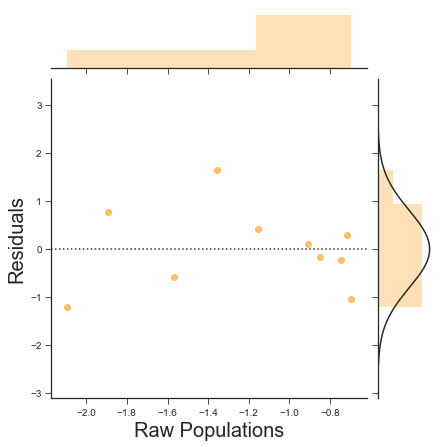

In [279]:
# build the MSM

from msmbuilder.io import load_trajs, save_trajs, save_generic
from msmbuilder.msm import MarkovStateModel

## Load
meta, ktrajs = load_trajs('ktrajs')

## Fit
msm = MarkovStateModel(lag_time=50, n_timescales=10, verbose=False)
msm.fit(list(ktrajs.values()))

## Transform
microktrajs = {}
for k, v in ktrajs.items():
    microktrajs[k] = msm.partial_transform(v)

## Save
print(msm.summarize())
save_generic(msm, 'msm.pickl')
save_trajs(microktrajs, 'microktrajs', meta)

## Plot residuals

_ = msme.plot_pop_resids(msm, color='tarragon')

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


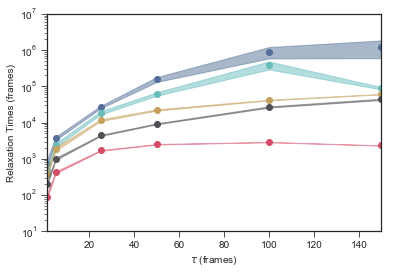

In [280]:
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=5, verbose=False)
                     for x in [1, 5, 25, 50, 100, 150 ]
]

for msm in msm_list:
    msm.fit(list(ktrajs.values()))
    
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

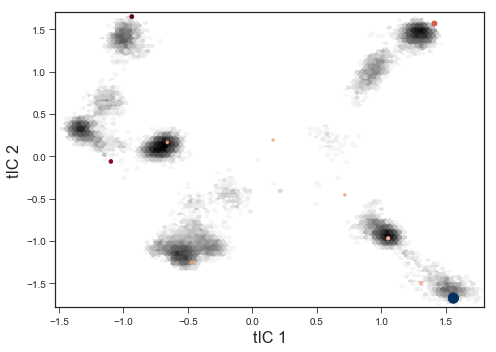

In [281]:
#Plot populations and eigvectors from microstate MSM

from msmbuilder.io import load_trajs, load_generic

sns.set_style('ticks')
colors = sns.color_palette()

## Load
kmeans = load_generic('kmeans.pickl')
msm = load_generic('msm.pickl')
meta, ttrajs = load_trajs('ttrajs')
txx = np.concatenate(list(ttrajs.values()))


## Plot microstates
def plot_microstates(ax):
    ax.hexbin(txx[:, 0], txx[:, 1],
              cmap='Greys',
              mincnt=1,
              bins='log',
              )

    scale = 100 / np.max(msm.populations_)
    add_a_bit = 5
    ax.scatter(kmeans.cluster_centers_[msm.state_labels_, 0],
               kmeans.cluster_centers_[msm.state_labels_, 1],
               s=scale * msm.populations_ + add_a_bit,
               c=msm.left_eigenvectors_[:, 1],
               cmap='RdBu'
               )
    ax.set_xlabel("tIC 1", fontsize=16)
    ax.set_ylabel("tIC 2", fontsize=16)
    # ax.colorbar(label='First Dynamical Eigenvector', fontsize=16)


## Plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_microstates(ax)
fig.tight_layout()
plt.show()
#fig.savefig('msm-microstates.pdf')

# The microstate centers are shown as circles on the tIC heatmap. 
# They are sized according to state population. 
# They are colored according to the first dynamical eigenvector. 
# The slowest processes is a transition from red states to blue.

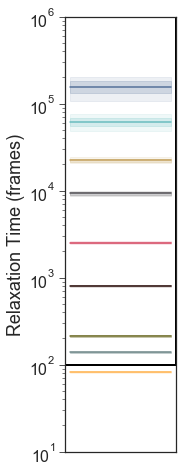

In [282]:
## Plot timescales

_ = msme.plot_timescales(msm, ylabel=r'Relaxation Time (frames)')

In [283]:
for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts / 10
    uncertainty_ns = ts_u  / 10
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

Timescale 1: 15622.50 ± 2397.70 ns
Timescale 2: 6191.42 ± 667.49 ns
Timescale 3: 2234.66 ± 90.98 ns
Timescale 4: 926.73 ± 28.55 ns
Timescale 5: 252.60 ± 3.80 ns
Timescale 6: 80.42 ± 1.12 ns
Timescale 7: 21.27 ± 0.36 ns
Timescale 8: 13.82 ± 0.10 ns
Timescale 9: 8.20 ± 0.09 ns


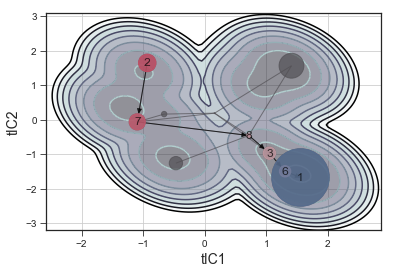

In [284]:
data = np.asarray((txx[:, 0], txx[:, 1]))
data = np.transpose(data)


assigns = (list(ktrajs.values()))

pi_0 = msm.populations_[np.concatenate(assigns, axis=0)]
rs = np.random.RandomState(42)


# Free Energy Surface
ax = msme.plot_free_energy(data, obs=(0, 1), temperature=323., n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=10., vmin=-1.,
                          n_levels=10, cut=5, xlabel='tIC1',
                          ylabel='tIC2', random_state=rs,
                          shade=True,
                      clabel=False,
                      clabel_kwargs={'fmt': '%.1f'},
                      cbar=False,
                      cbar_kwargs={'format': '%.1f', 'label': 'Free energy (kcal/mol)'})

# MSM Network


pos = dict(zip(range(kmeans.n_clusters), kmeans.cluster_centers_[:,[0,1]]))
#pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)

# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['pomegranate', 'lightgrey', 'rawdenim'])
_ = msme.plot_tpaths(msm, [2], [1], pos=pos, node_color=cmap(w),
                     alpha=.7, edge_color='black', ax=ax,
                    )

In [285]:
# sample the msm

from msmbuilder.io import load_trajs, save_generic, preload_top, backup, load_generic
from msmbuilder.io.sampling import sample_msm

## Load
meta, ttrajs = load_trajs('ttrajs')
msm = load_generic('msm.pickl')
kmeans = load_generic('kmeans.pickl')

## Sample
# Warning: make sure ttrajs and kmeans centers have
# the same number of dimensions
inds = sample_msm(ttrajs, kmeans.cluster_centers_, msm, n_steps=200, stride=1)
save_generic(inds, "msm-traj-inds.pickl")

## Make trajectory
top = preload_top(meta)
traj = md.join(
    md.load_frame(meta.loc[traj_i]['traj_fn'], index=frame_i, top=top)
    for traj_i, frame_i in inds)

## Save
traj_fn = "msm-traj.xtc"
#backup(traj_fn)
traj.save(traj_fn)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: msm-traj-inds.pickl exists. Moving it to msm-traj-inds.pickl.bak.8
  BackupWarning)


PCA

In [286]:
#Reduce dimensionality with PCA

from msmbuilder.io import load_trajs, save_trajs, save_generic
from msmbuilder.decomposition import PCA

## Load
pca = PCA(n_components=5)
meta, ftrajs = load_trajs("ftrajs")

## Fit
p = pca.fit(ftrajs.values())
pca.fit(ftrajs.values())

## Transform
ptrajs = {}
for k, v in ftrajs.items():
    ptrajs[k] = pca.partial_transform(v)

## Save
save_trajs(ptrajs, 'ptrajs', meta)
save_generic(pca, 'pca.pickl')

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: ptrajs exists. Moving it to ptrajs.bak.3
  BackupWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/io/io.py:54: BackupWarning: pca.pickl exists. Moving it to pca.pickl.bak.3
  BackupWarning)


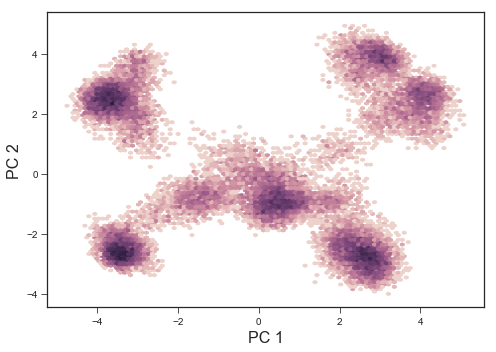

In [287]:
#"""Plot PCA-transformed coordinates

from msmbuilder.io import load_trajs, load_generic

sns.set_style('ticks')
colors = sns.color_palette()

## Load
tica = load_generic('pca.pickl')
meta, ptrajs = load_trajs('ptrajs')
pxx = np.concatenate(list(ptrajs.values()))


## Heatmap
def plot_heatmap(ax):
    ax.hexbin(pxx[:, 0], pxx[:, 1],
              cmap=sns.cubehelix_palette(as_cmap=True),
              mincnt=1,
              bins='log'
              )
    ax.set_xlabel("PC 1", fontsize=16)
    ax.set_ylabel("PC 2", fontsize=16)



## Plot 1
fig, ax = plt.subplots(figsize=(7, 5))
plot_heatmap(ax)
fig.tight_layout()
plt.show()
#fig.savefig('pca-heatmap.pdf')
#


/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


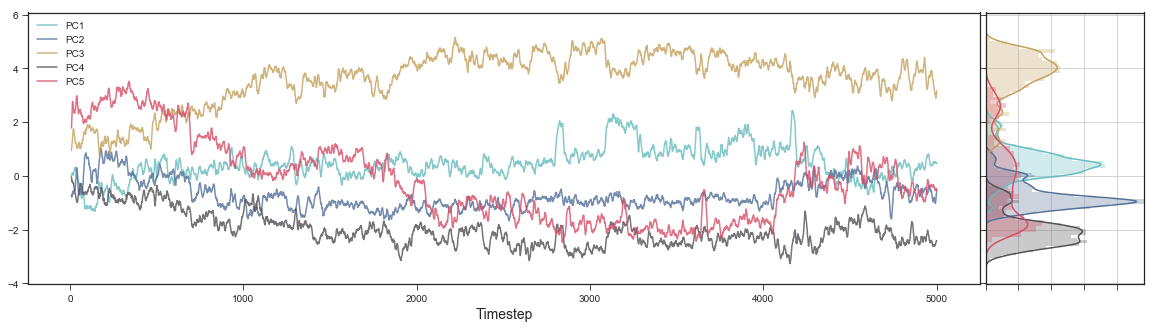

In [288]:
# MSME plotting

import msmexplorer as msme

pca_model = PCA(n_components=5)
pca_trajs = pca_model.fit_transform(ftrajs.values())

ax, side_ax = msme.plot_trace(pca_trajs[0][:, 0], window=10,
                              label='PC1', xlabel='Timestep')
_ = msme.plot_trace(pca_trajs[0][:, 1], window=10, label='PC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
__ = msme.plot_trace(pca_trajs[0][:, 2], window=10, label='PC3',
                    xlabel='Timestep', color='dijon', ax=ax,
                    side_ax=side_ax)
___ = msme.plot_trace(pca_trajs[0][:, 3], window=10, label='PC4',
                    xlabel='Timestep', color='carbon', ax=ax,
                    side_ax=side_ax)
____ = msme.plot_trace(pca_trajs[0][:, 4], window=10, label='PC5',
                    xlabel='Timestep', color='pomegranate', ax=ax,
                    side_ax=side_ax)

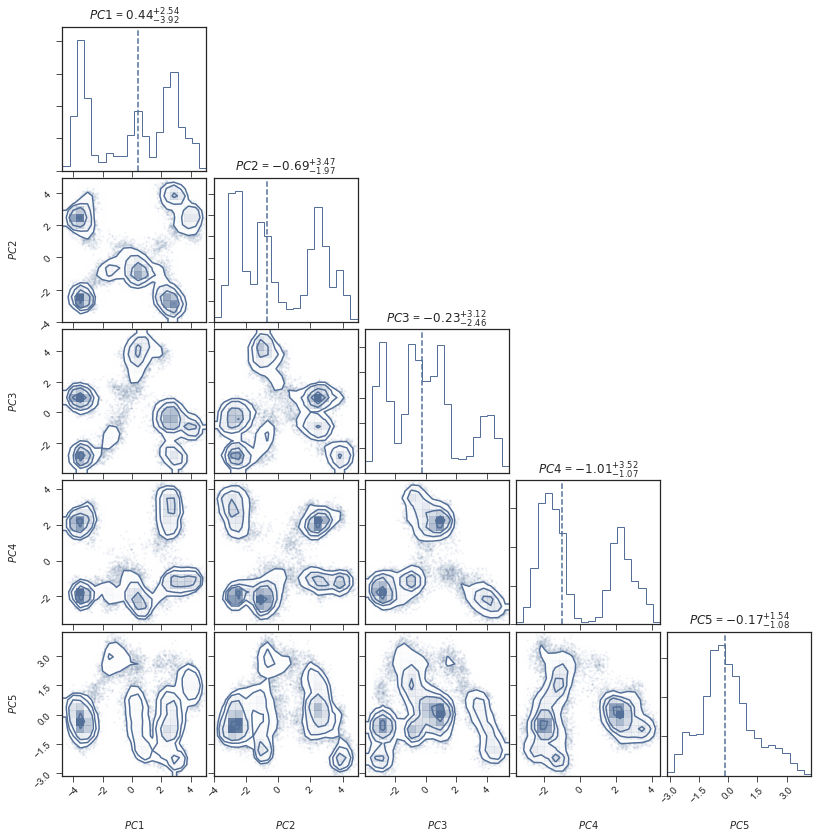

In [289]:
pxx = np.concatenate(pca_trajs)
_ = msme.plot_histogram(pxx, labels=['$PC1$', '$PC2$', '$PC3$', '$PC4$', '$PC5$'],
                    color='rawdenim', quantiles=(0.5,), smooth=0.5, show_titles=True)

In [290]:
from msmbuilder.dataset import dataset
from msmbuilder.preprocessing import RobustScaler
# Using scaled data

# test scaling

trajs = dataset("*SC*.xtc", topology="md.loop_SC_start.gro")
    
for traj in trajs:
    print(traj)

featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = featurizer.fit_transform(trajs)

scaler = RobustScaler()
scaled_data = scaler.fit_transform(diheds)

<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>


/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


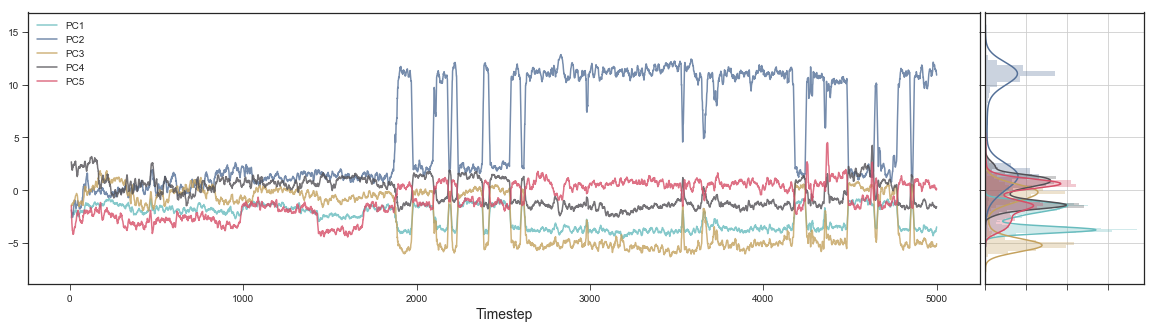

In [291]:
pca_model = PCA(n_components=5)
pca_trajs = pca_model.fit_transform(scaled_data)

ax, side_ax = msme.plot_trace(pca_trajs[0][:, 0], window=10,
                              label='PC1', xlabel='Timestep')
_ = msme.plot_trace(pca_trajs[0][:, 1], window=10, label='PC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
__ = msme.plot_trace(pca_trajs[0][:, 2], window=10, label='PC3',
                    xlabel='Timestep', color='dijon', ax=ax,
                    side_ax=side_ax)
___ = msme.plot_trace(pca_trajs[0][:, 3], window=10, label='PC4',
                    xlabel='Timestep', color='carbon', ax=ax,
                    side_ax=side_ax)
____ = msme.plot_trace(pca_trajs[0][:, 4], window=10, label='PC5',
                    xlabel='Timestep', color='pomegranate', ax=ax,
                    side_ax=side_ax)

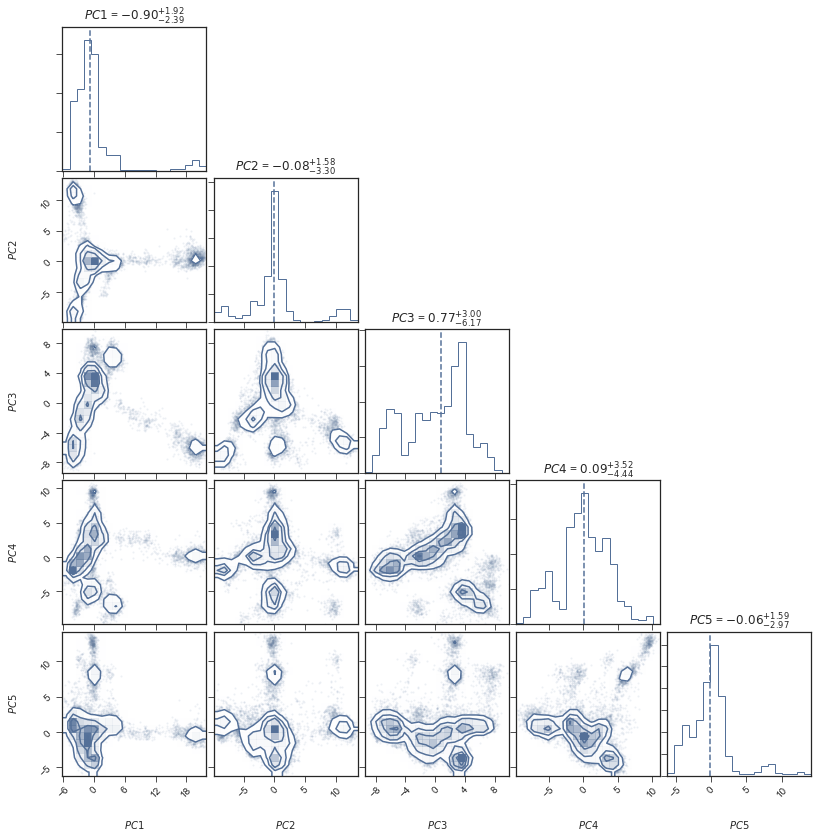

In [292]:
txx = np.concatenate(pca_trajs)
_ = msme.plot_histogram(txx, labels=['$PC1$', '$PC2$', '$PC3$', '$PC4$', '$PC5$'],
                    color='rawdenim', quantiles=(0.5,), smooth=0.5, show_titles=True)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


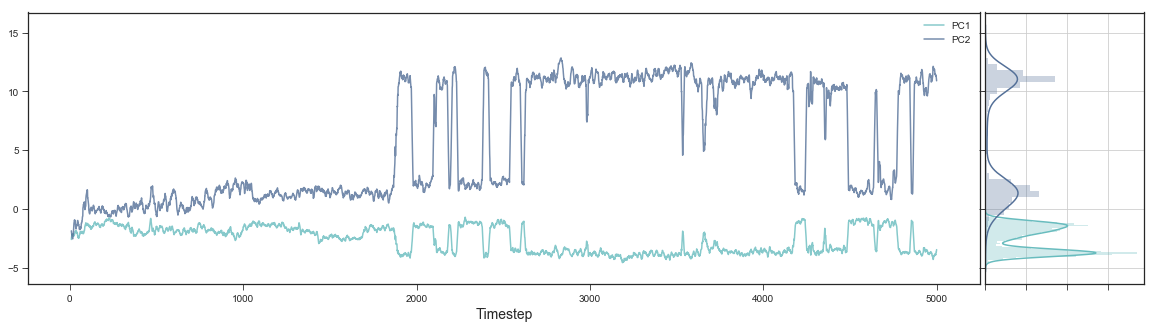

In [293]:
pca_model = PCA(n_components=2)
pca_trajs = pca_model.fit_transform(scaled_data)

ax, side_ax = msme.plot_trace(pca_trajs[0][:, 0], window=10,
                              label='PC1', xlabel='Timestep')
_ = msme.plot_trace(pca_trajs[0][:, 1], window=10, label='PC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)

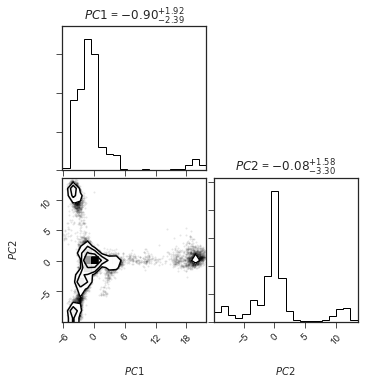

In [294]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(pca_trajs)
_ = msme.plot_histogram(txx, labels=['$PC1$', '$PC2$'],
                    show_titles=True)

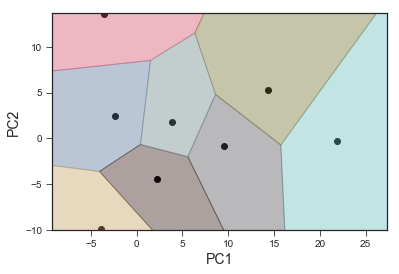

In [295]:
clusterer = KCenters(n_clusters=8, random_state=rs)
clustered_trajs = clusterer.fit_transform(pca_trajs)

_ = msme.plot_voronoi(clusterer, xlabel='PC1', ylabel='PC2')

MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


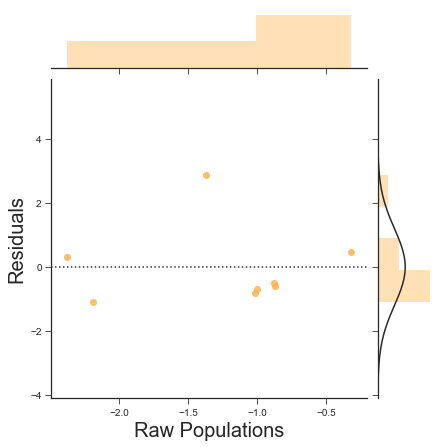

In [296]:
msm = MarkovStateModel(lag_time=125, n_timescales=10)
assigns = msm.fit_transform(clustered_trajs)

_ = msme.plot_pop_resids(msm, color='tarragon')

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


Timescale 1: 2238.20 ± 98.49 ns
Timescale 2: 86.45 ± 0.34 ns
Timescale 3: 41.64 ± 0.10 ns
Timescale 4: 25.48 ± 0.05 ns
Timescale 5: 17.26 ± 0.04 ns
Timescale 6: 15.20 ± 0.15 ns
Timescale 7: 2.73 ± 0.16 ns


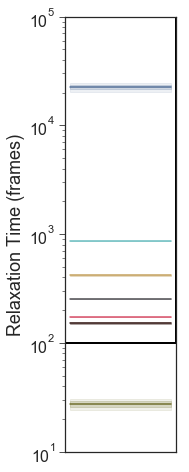

In [297]:
_ = msme.plot_timescales(msm, ylabel=r'Relaxation Time (frames)')

for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts / 10
    uncertainty_ns = ts_u / 10
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

In [298]:
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=5, verbose=False)
                     for x in [1, 5, 25, 125, 250]
]

for msm in msm_list:
    msm.fit(clustered_trajs)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


IndexError: index 4 is out of bounds for axis 0 with size 4

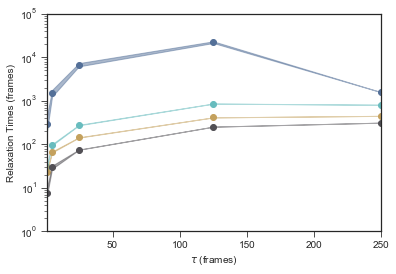

In [299]:
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

In [300]:
msm = msm_list[2]  # Choose the appropriate MSM from the list

### OVERRIDE
msm = MarkovStateModel(lag_time=50, n_timescales=10)
assigns = msm.fit_transform(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%


In [301]:
for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts / 10
    uncertainty_ns = ts_u / 10
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

Timescale 1: 1286.06 ± 77.57 ns
Timescale 2: 41.42 ± 0.29 ns
Timescale 3: 20.77 ± 0.09 ns
Timescale 4: 12.80 ± 0.04 ns
Timescale 5: 7.90 ± 0.03 ns
Timescale 6: 6.07 ± 0.09 ns
Timescale 7: 3.60 ± 0.08 ns


/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


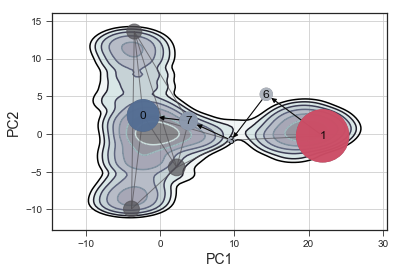

In [302]:
data = np.concatenate(pca_trajs, axis=0)
pi_0 = msm.populations_[np.concatenate(assigns, axis=0)]


# Free Energy Surface
ax = msme.plot_free_energy(data, obs=(0, 1), n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=5.,
                          n_levels=8, cut=5, xlabel='PC1',
                          ylabel='PC2', random_state=rs)

# MSM Network
pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)


# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['pomegranate', 'lightgrey', 'rawdenim'])
_ = msme.plot_tpaths(msm, [1], [0], pos=pos, node_color=cmap(w),
                     alpha=.9, edge_color='black', ax=ax)